In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

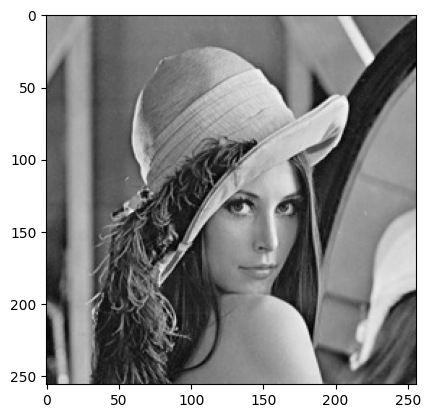

In [8]:
image = cv2.imread('asian_business_woman.jpg')

# „Ç´„É©„ÉºÁîªÂÉè„Åã„Çâ„Ç∞„É¨„Ç§ÁîªÂÉè„Å∏
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# „Ç¨„Ç¶„Çπ„Éï„Ç£„É´„Çø„Éº„ÇíÈÅ©Áî®„Åó„Å¶Âπ≥ÊªëÂåñ
smoothed = cv2.GaussianBlur(gray, (5, 5), sigmaX=1)

#Ë°®Á§∫
plt.imshow(gray, cmap='gray')

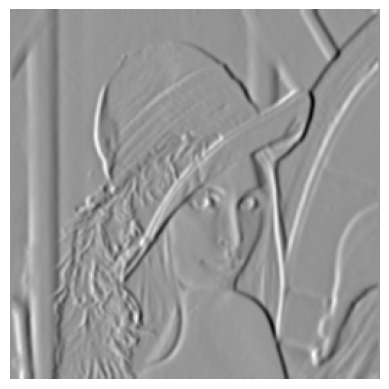

In [9]:
#XÊñπÂêëÂæÆÂàÜ
dx = cv2.Sobel(smoothed, cv2.CV_64F, dx=1, dy=0, ksize=3)
#label„Ç™„Éï
plt.axis('off')
#ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(dx, cmap='gray')

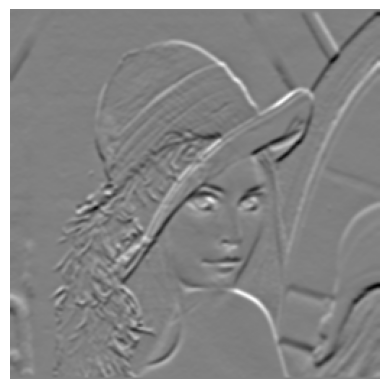

In [10]:
# YÊñπÂêëÂæÆÂàÜ
dy = cv2.Sobel(smoothed, cv2.CV_64F, dx=0, dy=1, ksize=3)
#label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(dy, cmap='gray')

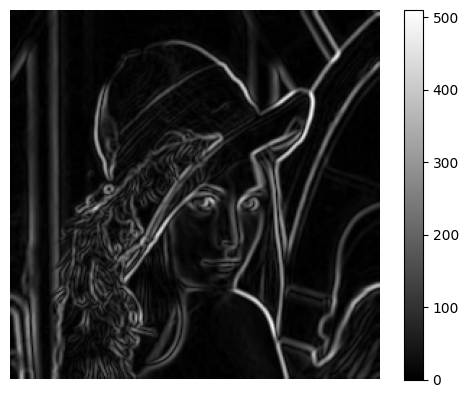

In [11]:
# ÂãæÈÖçÂº∑Â∫¶„ÇíË®àÁÆó
gradient_magnitude = cv2.magnitude(dx, dy)
# ÁµêÊûú„Çí‰øùÂ≠ò„Åæ„Åü„ÅØË°®Á§∫
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')
plt.colorbar()

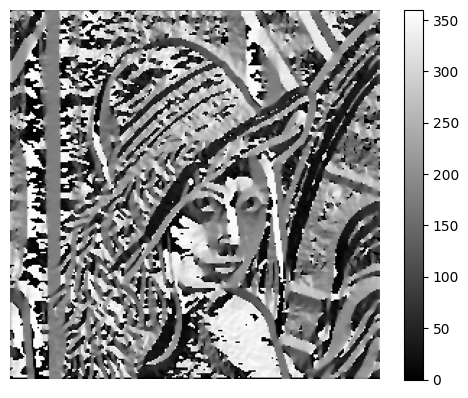

In [12]:
# ÂãæÈÖçÊñπÂêë„ÅÆË®àÁÆó
gradient_direction = cv2.phase(dx, dy, angleInDegrees=True)

plt.axis('off')

plt.imshow(gradient_direction, cmap='gray')
plt.colorbar(orientation='vertical')

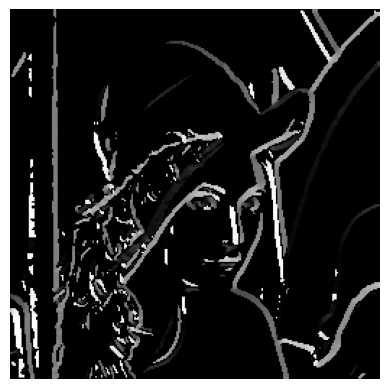

In [13]:
#„ÄÄgradient_direction„ÅÆÊúÄÂ∞è„É¨„Éô„É´„Åß„ÅÆÈñæÂÄ§„ÅÆÂ§ß„Åç„Åï„ÇíÊ±∫„ÇÅ„Çã
min_threshold = 100
# ÊñπÂêë„ÅÆÈñæÂÄ§Âá¶ÁêÜ(ÊúÄÂ∞èÂÄ§200‰ª•‰∏ã„Çí0„Å´„Åô„Çã)
modified_gradient_direction = np.where(gradient_magnitude > min_threshold, gradient_direction, 0)

# label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(modified_gradient_direction, cmap='gray')

In [15]:
#„ÄÄgradient_magnitude„ÇíÊúÄÂ§ßÊäëÂà∂ÔºàNMSÔºâÂá¶ÁêÜ, „Éê„Ç§„É™„Éã„Ç¢Ë£úÈñì„ÅÇ„Çä„ÄÇ

def bilinear_interpolate(img, width, height, x, y):
        """
        img: 2DÈÖçÂàó, x: ÂàóÂ∫ßÊ®ô, y: Ë°åÂ∫ßÊ®ô
        """
        if x < 0 or x >= width-1 or y < 0 or y >= height-1:
            return 0.0
        x0, y0 = int(np.floor(x)), int(np.floor(y))
        x1, y1 = x0 + 1, y0 + 1
        Ia = img[y0, x0]
        Ib = img[y0, x1]
        Ic = img[y1, x0]
        Id = img[y1, x1]
        wa = (x1 - x) * (y1 - y)
        wb = (x - x0) * (y1 - y)
        wc = (x1 - x) * (y - y0)
        wd = (x - x0) * (y - y0)
        return wa*Ia + wb*Ib + wc*Ic + wd*Id

def non_max_suppression(gradient_magnitude, gradient_direction):
    """
    „Éê„Ç§„É™„Éã„Ç¢Ë£úÈñì„Çí‰Ωø„Å£„ÅüÈùûÊúÄÂ§ßÊäëÂà∂

    Parameters:
    - gradient_magnitude: ÂãæÈÖçÂº∑Â∫¶„ÅÆ2DÈÖçÂàó
    - gradient_direction: ÂãæÈÖçÊñπÂêëÔºàÂ∫¶Ôºâ„ÅÆ2DÈÖçÂàó

    Returns:
    - output: ÈùûÊúÄÂ§ßÊäëÂà∂Âæå„ÅÆ2DÈÖçÂàó
    """
    height, width = gradient_magnitude.shape
    output = np.zeros((height, width), dtype=np.float32)

    # ËßíÂ∫¶„Çí„É©„Ç∏„Ç¢„É≥„Å´Â§âÊèõ
    angle = gradient_direction * np.pi / 180.0

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            theta = angle[i, j]
            # ÂãæÈÖçÊñπÂêë„ÅÆÂçò‰Ωç„Éô„ÇØ„Éà„É´
            dx = np.cos(theta)
            dy = np.sin(theta)

            # ‚ë† Ê≠£ÊñπÂêë„Çµ„É≥„Éó„É™„É≥„Ç∞ÁÇπ
            x_pos = j + dx
            y_pos = i + dy
            q = bilinear_interpolate(gradient_magnitude,width,height, x_pos, y_pos)

            # ‚ë° ÈÄÜÊñπÂêë„Çµ„É≥„Éó„É™„É≥„Ç∞ÁÇπ
            x_neg = j - dx
            y_neg = i - dy
            r = bilinear_interpolate(gradient_magnitude, width,height,x_neg, y_neg)

            # ÈùûÊúÄÂ§ßÊäëÂà∂
            mag = gradient_magnitude[i, j]
            if mag >= q and mag >= r:
                output[i, j] = mag
            else:
                output[i, j] = 0.0

    return output

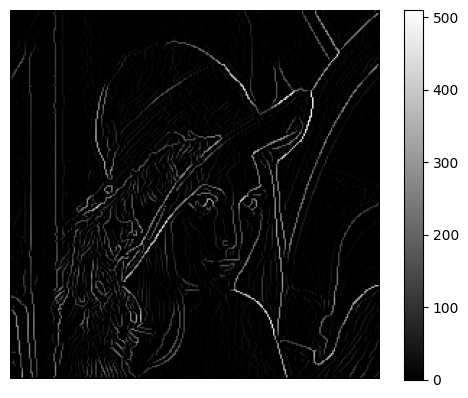

In [16]:
# NMS„ÇíÈÅ©Áî®
nms_result = non_max_suppression(gradient_magnitude, modified_gradient_direction)
# label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(nms_result, cmap='gray')
plt.colorbar(orientation='vertical')

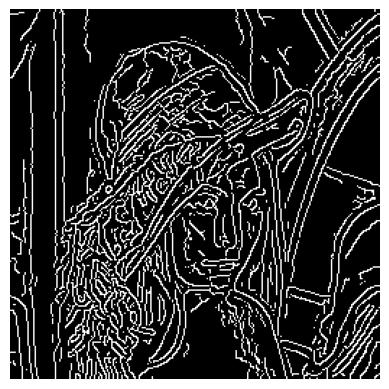

In [17]:
# Canny„Ç®„ÉÉ„Ç∏Ê§úÂá∫„ÇíÈÅ©Áî®„ÄÅ„Ç∑„Ç¨„Éû=1.4, ùë°_ùëôùëúùë§=0.05,„ÄÄùë°_‚Ñéùëñùëî‚Ñé=0.1
#cv2.Canny()„Å´„ÅØ„Ç∑„Ç¨„Éû„ÅÆÂºïÊï∞„ÅØ„Å™„ÅÑ„ÅÆ„Åß„ÄÅ„Ç¨„Ç¶„Çπ„Éï„Ç£„É´„Çø„ÅßÂπ≥ÊªëÂåñ„Åó„Å¶„Åã„ÇâCanny„ÇíÈÅ©Áî®
smoothed = cv2.GaussianBlur(image, (5, 5), sigmaX=1.4)  # Adjust sigma here
edges = cv2.Canny(smoothed, 0.05 * 255, 0.1 * 255, L2gradient=True)
# label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(edges, cmap='gray')

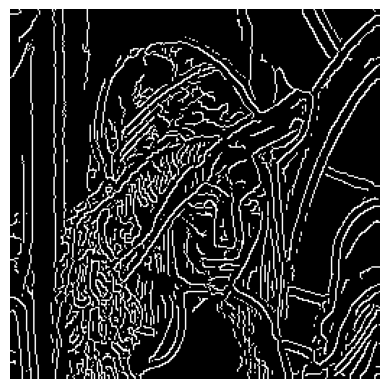

In [18]:
#„Ç∑„Ç¨„Éû=4*1.4, ùë°_ùëôùëúùë§=0.05,„ÄÄùë°_‚Ñéùëñùëî‚Ñé=0.1
smoothed = cv2.GaussianBlur(image, (5, 5), sigmaX=10*1.4)  # Adjust sigma here
edges = cv2.Canny(smoothed, 0.05 * 255, 0.1 * 255, L2gradient=True)
# label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(edges, cmap='gray')


In [19]:
# ÂéüÂßãÁöÑ„Å™Canny„Ç®„ÉÉ„Ç∏Ê§úÂá∫„Ç¢„É´„Ç¥„É™„Ç∫„É†„ÇíËá™‰Ωú
def canny_with_sigma(img,  sigma=1.0, low_thresh=50, high_thresh=150):
    """
    Canny edge detection with direct sigma input.
    
    Parameters:
    - img: ÂÖ•ÂäõÁîªÂÉèÔºà„Ç∞„É¨„Éº„Çπ„Ç±„Éº„É´Ôºâ
    - sigma: „Ç¨„Ç¶„Ç∑„Ç¢„É≥Âπ≥ÊªëÂåñ„ÅÆÊ®ôÊ∫ñÂÅèÂ∑Æ
    - low_thresh: ‰∫åÈáçÈñæÂÄ§„ÅÆ‰ΩéÈñæÂÄ§
    - high_thresh: ‰∫åÈáçÈñæÂÄ§„ÅÆÈ´òÈñæÂÄ§
    
    Returns:
    - edges: Ê§úÂá∫„Åï„Çå„Åü„Ç®„ÉÉ„Ç∏ÁîªÂÉèÔºà‰∫åÂÄ§ÁîªÂÉèÔºâ
    """
    # 1. „Ç¨„Ç¶„Ç∑„Ç¢„É≥Âπ≥ÊªëÂåñ
    # „Ç´„Éº„Éç„É´„Çµ„Ç§„Ç∫„ÅØ sigma*6 „ÇíÁõÆÂÆâ„Å´„ÄÅÂ•áÊï∞„Å´‰∏∏„ÇÅ„Çã
    ksize = int(2 * round(3 * sigma) + 1)
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    # 2. Sobel „Å´„Çà„ÇãÂãæÈÖçË®àÁÆó
    gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.hypot(gx, gy)
    grad_ang = np.arctan2(gy, gx)  # -pi to pi

    # 3. ÈùûÊ•µÂ§ßÊäëÂà∂
    H, W = img.shape
    nms = np.zeros((H, W), dtype=np.float64)
    angle = grad_ang * (180.0 / np.pi)
    angle[angle < 0] += 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255
            r = 255
            # ÊñπÂêë„Å´Âøú„Åò„Å¶Èö£Êé•„Éî„ÇØ„Çª„É´„ÇíÈÅ∏Êäû
            a = angle[i, j]
            if (0 <= a < 22.5) or (157.5 <= a <= 180):
                q = grad_mag[i, j+1]
                r = grad_mag[i, j-1]
            elif 22.5 <= a < 67.5:
                q = grad_mag[i+1, j-1]
                r = grad_mag[i-1, j+1]
            elif 67.5 <= a < 112.5:
                q = grad_mag[i+1, j]
                r = grad_mag[i-1, j]
            elif 112.5 <= a < 157.5:
                q = grad_mag[i-1, j-1]
                r = grad_mag[i+1, j+1]

            if grad_mag[i, j] >= q and grad_mag[i, j] >= r:
                nms[i, j] = grad_mag[i, j]
            else:
                nms[i, j] = 0

    # 4. ‰∫åÈáçÈñæÂÄ§Âá¶ÁêÜ
    strong = high_thresh
    weak = low_thresh
    res = np.zeros((H, W), dtype=np.uint8)

    strong_i, strong_j = np.where(nms >= strong)
    weak_i, weak_j     = np.where((nms <= strong) & (nms >= weak))

    res[strong_i, strong_j] = 255
    res[weak_i, weak_j]     = 75  # ‰ªÆ„ÅÆÂº±„Ç®„ÉÉ„Ç∏ÂÄ§

    # 5. „Éí„Çπ„ÉÜ„É™„Ç∑„Çπ„Å´„Çà„Çã„Ç®„ÉÉ„Ç∏ËøΩË∑°
    for i in range(1, H-1):
        for j in range(1, W-1):
            if res[i, j] == 75:  # Âº±„Ç®„ÉÉ„Ç∏
                # 8ËøëÂÇç„Å´Âº∑„Ç®„ÉÉ„Ç∏„Åå„ÅÇ„Çå„Å∞„Ç®„ÉÉ„Ç∏„Å®„Åó„Å¶ÊÆã„Åô
                if 255 in res[i-1:i+2, j-1:j+2]:
                    res[i, j] = 255
                else:
                    res[i, j] = 0

    return res

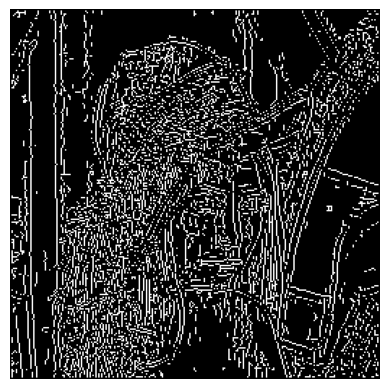

In [20]:
edges_1 = canny_with_sigma(gray, sigma=0.5, low_thresh=0.05 * 255, high_thresh=0.1 * 255)
# label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(edges_1, cmap='gray')

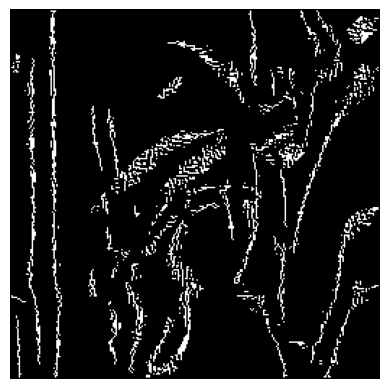

In [21]:
edges_2 = canny_with_sigma(gray, sigma=5, low_thresh=0.05 * 255, high_thresh=0.1 * 255)
# label„Ç™„Éï
plt.axis('off')
# ÁµêÊûú„ÇíË°®Á§∫
plt.imshow(edges_2, cmap='gray')